# Washington Mystics Data Analyst Modeling Assessment
### Grace Casey

---
### Overview
In this notebook I aim to predict the likelihood of a player winning MVP in a given WNBA season by combining player performance data, team success metrics, and advanced basketball statistics. The analysis follows a structured process of data exploration, feature engineering, machine learning model training, and out-of-sample predictions for the 2024 MVP race.

# 1. Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
#Read in files

player_info = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/player_info.csv')
player_stats = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/player_stats.csv')
mvp_voting = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mvp_voting.csv')
team_player_on_court = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/team_player_on_court.csv')
team_player_off_court = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/team_player_off_court.csv')
opponent_player_on_court = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/opponent_player_on_court.csv')
opponent_player_off_court = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/opponent_player_off_court.csv')
team_records = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/team_records.csv')


In [ ]:
dfs = {
    'player_info': player_info,
    'player_stats': player_stats,
    'mvp_voting': mvp_voting,
    'team_player_on_court': team_player_on_court,
    'team_player_off_court': team_player_off_court,
    'opponent_player_on_court': opponent_player_on_court,
    'opponent_player_off_court': opponent_player_off_court,
    'team_records': team_records
}

# 2. EDA (before merging)
In this section, I explore the different datasets, identify key features for MVP prediction. Before merging datasets, I explored each table individually to assess data quality, identify missing values, and better understand the range of player performance metrics available. This helped inform later decisions on feature selection and model building.

In [ ]:
def eda_report(df, name):
    print(f"{name} Overview:")
    print(f"Shape: {df.shape}")
    print("Missing Values (%):")
    print(df.isnull().mean().sort_values(ascending=False).head(10) * 100)
    print("\nZero Value Columns:")
    print((df == 0).sum().sort_values(ascending=False).head(10))
    print("\nBasic Stats:")
    print(df.describe().T[['mean', 'min', 'max', 'std']].head(5))
    print("\nData Types:")
    print(df.dtypes)
    print("=" * 50)


for name, df in dfs.items():
    eda_report(df, name)

player_info Overview:
Shape: (459, 7)
Missing Values (%):
draft_round      17.647059
draft_pick       17.647059
weight            9.368192
height_inches     2.178649
display_name      0.000000
nba_person_id     0.000000
birth_date        0.000000
dtype: float64

Zero Value Columns:
weight           2
display_name     0
nba_person_id    0
birth_date       0
draft_round      0
draft_pick       0
height_inches    0
dtype: int64

Basic Stats:
                        mean       min        max            std
nba_person_id  981148.854031  100342.0  1642534.0  718995.476940
draft_round         1.571429       1.0        3.0       0.707241
draft_pick         12.841270       1.0       36.0       9.209394
height_inches      72.374165      63.0       83.0       3.527678
weight            171.593750       0.0      315.0      27.883248

Data Types:
display_name      object
nba_person_id      int64
birth_date        object
draft_round      float64
draft_pick       float64
height_inches    float64
weig

During EDA, I identified several features with high missing rates or zero-filled columns. These were either removed or handled after the merging phase to improve model performance.

# 3. Data Merging
In this section I join together all of the datasets into one master dataframe in order to use for modeling.



In [ ]:
#merge all the relevant datasets into one.
master_df = player_stats.merge(player_info[['nba_person_id','display_name', 'height_inches' ]], on= 'nba_person_id', how= 'left')

master_df = master_df.merge(team_player_on_court, on=['nba_person_id', 'nba_season'], how= 'left', suffixes= ('', '_on_court'))
master_df = master_df.merge(team_player_off_court, on=['nba_person_id', 'nba_season'], how= 'left', suffixes= ('', '_off_court'))

master_df = master_df.merge(opponent_player_on_court, on=['nba_person_id', 'nba_season'], how= 'left', suffixes= ('', '_opp_on'))
master_df = master_df.merge(opponent_player_off_court, on=['nba_person_id', 'nba_season'], how= 'left', suffixes= ('', '_opp_off'))

master_df = master_df.merge(mvp_voting[['mvp_rank', 'pts_share','nba_person_id','nba_season']],on=['nba_person_id', 'nba_season'], how= 'left')

master_df = master_df.merge(team_records[['conference_rank', 'league_rank', 'team_code', 'nba_season', 'nba_team_id',  'wins', 'losses', 'wlp','division_rank']], on=['nba_season', 'nba_team_id'], how= 'left')



#4. EDA (after merging)

After merging, I performed a series of checks to verify that the combined dataset correctly aligned player stats, on/off court impact, MVP voting shares, and team success. The final merged dataset contains player-season-level observations across 9 WNBA seasons

In [ ]:
master_df.info()
print(master_df.shape)
print(master_df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6121 entries, 0 to 6120
Columns: 749 entries, nba_person_id to division_rank
dtypes: float64(33), int64(708), object(8)
memory usage: 35.0+ MB
(6121, 749)
       nba_person_id   nba_team_id   nba_season           gp           mp  \
count   6.121000e+03  6.121000e+03  6121.000000  6121.000000  6121.000000   
mean    1.069127e+06  1.611661e+09  2020.653651    11.483418   195.367500   
std     6.984184e+05  4.582557e+00     2.500972    10.477416   272.517215   
min     1.004450e+05  1.611661e+09  2016.000000     1.000000     0.050000   
25%     2.038350e+05  1.611661e+09  2019.000000     3.000000    16.720000   
50%     1.628242e+06  1.611661e+09  2021.000000     8.000000    69.800000   
75%     1.630100e+06  1.611661e+09  2023.000000    17.000000   277.791667   
max     1.642534e+06  1.611661e+09  2024.000000    40.000000  1489.000500   

            seconds  clutch_time_seconds  garbage_time_seconds  \
count   6121.000000          3821.0

In [ ]:
#Null Inspection -- % missing values for each column
null_pct = master_df.isnull().sum() / len(master_df) * 100
null_pct = null_pct[null_pct > 0].sort_values(ascending=False)
print("Null % per column:")
print(null_pct)


Null % per column:
pts_share                            98.121222
mvp_rank                             98.121222
clutch_time_seconds_on_court         37.575560
clutch_time_seconds_opp_on           37.575560
clutch_time_seconds                  37.575560
non_garbage_time_seconds_on_court     8.233949
non_garbage_time_seconds_opp_on       8.233949
non_garbage_time_seconds              8.233949
garbage_time_seconds_on_court         5.195230
garbage_time_seconds                  5.195230
garbage_time_seconds_opp_on           5.195230
clutch_time_seconds_off_court         3.528835
clutch_time_seconds_opp_off           3.528835
garbage_time_seconds_opp_off          0.702500
garbage_time_seconds_off_court        0.702500
height_inches                         0.147035
pts_off_tov_allowed_opp_on            0.032674
dtype: float64


In [ ]:
#Check object types columns
string_cols = master_df.select_dtypes(include='object').columns
print("String Columns:", list(string_cols))
print(master_df[string_cols].head(10))
print("pts_share values:",master_df['pts_share'].unique())

String Columns: ['time_added', 'display_name', 'time_added_on_court', 'time_added_off_court', 'time_added_opp_on', 'time_added_opp_off', 'pts_share', 'team_code']
       time_added          display_name time_added_on_court  \
0  10/30/24 23:27        Amanda Zahui B       10/31/24 0:36   
1  10/30/24 23:27         Jonquel Jones       10/31/24 0:36   
2  10/30/24 23:27        Kahleah Copper       10/31/24 0:36   
3  10/30/24 23:27       Kayla Alexander       10/31/24 0:36   
4  10/30/24 23:27         Glory Johnson       10/31/24 0:36   
5  10/30/24 23:27         Kayla McBride       10/31/24 0:36   
6  10/30/24 23:27         Sydney Colson       10/31/24 0:36   
7  10/30/24 23:27  Imani McGee-Stafford       10/31/24 0:36   
8  10/30/24 23:27         Aerial Powers       10/31/24 0:36   
9  10/30/24 23:27         Dearica Hamby       10/31/24 0:36   

  time_added_off_court time_added_opp_on time_added_opp_off pts_share  \
0        10/9/24 14:55     10/31/24 0:39      10/9/24 14:55       NaN 

In [ ]:
#Converting pts_share to float instead of string with %
master_df['pts_share'] = master_df['pts_share'].str.rstrip('%').astype(float) / 100

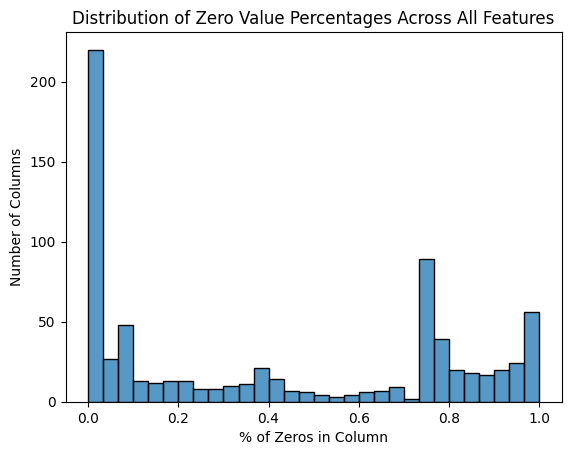

In [ ]:
#Zero Percentage Distribution- how many columns have data that is all 0?
import matplotlib.pyplot as plt
zero_counts = (master_df == 0).mean()
sns.histplot(zero_counts, bins=30)
plt.title("Distribution of Zero Value Percentages Across All Features")
plt.xlabel("% of Zeros in Column")
plt.ylabel("Number of Columns")
plt.show()

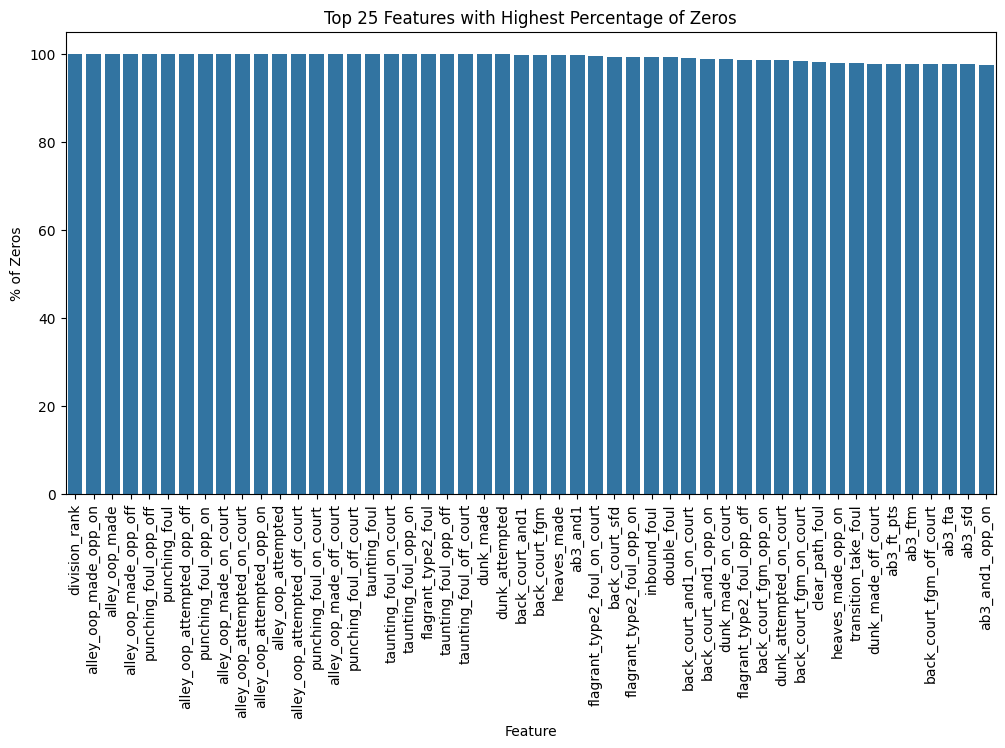

In [ ]:
# Calculate % of zeros
zero_percentage = (master_df == 0).mean() * 100

# Top 25 columns with the most zeroes
top_25_zeros = zero_percentage.sort_values(ascending=False).head(50)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_25_zeros.index, y=top_25_zeros.values)
plt.xticks(rotation=90)
plt.title("Top 25 Features with Highest Percentage of Zeros")
plt.ylabel("% of Zeros")
plt.xlabel("Feature")
plt.show()


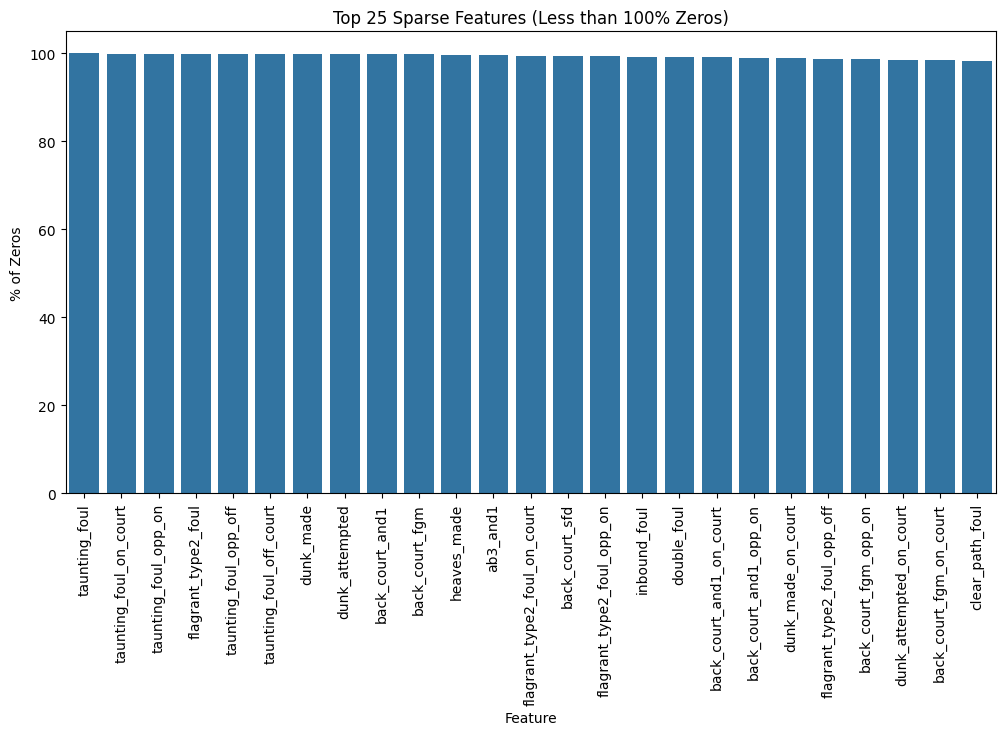

In [ ]:
# Calculate % of zeros
zero_percentage = (master_df == 0).mean() * 100

# Exclude features that are 100% zero
zero_percentage_filtered = zero_percentage[zero_percentage < 100]

# Get the top 25 features with the highest zero percentages (excluding 100% zeros)
top_25_sparse = zero_percentage_filtered.sort_values(ascending=False).head(25)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_25_sparse.index, y=top_25_sparse.values)
plt.xticks(rotation=90)
plt.title("Top 25 Sparse Features (Less than 100% Zeros)")
plt.ylabel("% of Zeros")
plt.xlabel("Feature")
plt.show()


To optimize model performance, I removed features where more than 95% of values were exactly zero, as they are unlikely to contribute meaningful information to the model. First pass identifies nad removes columns with no predictive value (100% zeros), second pass removes low signal columns (<5% non-zero).

In [ ]:
def check_zero_columns(df, threshold=1, protected_cols = []):
    zero_counts = (df == 0).mean()
    cols_to_drop = zero_counts[zero_counts >= threshold].index
    #remove protected columns frmo the list to drop
    cols_to_drop = [col for col in cols_to_drop if col not in protected_cols]
    print(f"{len(cols_to_drop)} Columns would be dropped:")
    print(list(cols_to_drop))
    return cols_to_drop


In [ ]:
check_zero_columns(master_df)

16 Columns would be dropped:
['alley_oop_made', 'alley_oop_attempted', 'punching_foul', 'alley_oop_made_on_court', 'alley_oop_attempted_on_court', 'punching_foul_on_court', 'alley_oop_made_off_court', 'alley_oop_attempted_off_court', 'punching_foul_off_court', 'alley_oop_made_opp_on', 'alley_oop_attempted_opp_on', 'punching_foul_opp_on', 'alley_oop_made_opp_off', 'alley_oop_attempted_opp_off', 'punching_foul_opp_off', 'division_rank']


['alley_oop_made',
 'alley_oop_attempted',
 'punching_foul',
 'alley_oop_made_on_court',
 'alley_oop_attempted_on_court',
 'punching_foul_on_court',
 'alley_oop_made_off_court',
 'alley_oop_attempted_off_court',
 'punching_foul_off_court',
 'alley_oop_made_opp_on',
 'alley_oop_attempted_opp_on',
 'punching_foul_opp_on',
 'alley_oop_made_opp_off',
 'alley_oop_attempted_opp_off',
 'punching_foul_opp_off',
 'division_rank']

In [ ]:
def drop_zero_columns(df, threshold=1, protected_cols =[]):
    #remove protected columns frmo the list to drop
    cols_to_drop = check_zero_columns(df, threshold, protected_cols)
    print(f"Dropping {len(cols_to_drop)} Columns with >={threshold*100}% Zero Values")
    return df.drop(columns=cols_to_drop)


In [ ]:
master_df = drop_zero_columns(master_df)

16 Columns would be dropped:
['alley_oop_made', 'alley_oop_attempted', 'punching_foul', 'alley_oop_made_on_court', 'alley_oop_attempted_on_court', 'punching_foul_on_court', 'alley_oop_made_off_court', 'alley_oop_attempted_off_court', 'punching_foul_off_court', 'alley_oop_made_opp_on', 'alley_oop_attempted_opp_on', 'punching_foul_opp_on', 'alley_oop_made_opp_off', 'alley_oop_attempted_opp_off', 'punching_foul_opp_off', 'division_rank']
Dropping 16 Columns with >=100% Zero Values


In [ ]:
check_zero_columns(master_df, 0.95)

53 Columns would be dropped:
['heaves_made', 'dunk_made', 'dunk_attempted', 'ab3_sfd', 'ab3_and1', 'ab3_ftm', 'ab3_fta', 'ab3_ft_pts', 'back_court_fgm', 'back_court_sfd', 'back_court_and1', 'away_from_play_foul', 'clear_path_foul', 'double_foul', 'flagrant_type2_foul', 'inbound_foul', 'taunting_foul', 'transition_take_foul', 'movement3_fgm', 'heaves_made_on_court', 'dunk_made_on_court', 'dunk_attempted_on_court', 'ab3_and1_on_court', 'back_court_fgm_on_court', 'back_court_sfd_on_court', 'back_court_and1_on_court', 'double_foul_on_court', 'flagrant_type2_foul_on_court', 'inbound_foul_on_court', 'taunting_foul_on_court', 'dunk_made_off_court', 'dunk_attempted_off_court', 'back_court_fgm_off_court', 'back_court_and1_off_court', 'flagrant_type2_foul_off_court', 'taunting_foul_off_court', 'heaves_made_opp_on', 'dunk_made_opp_on', 'dunk_attempted_opp_on', 'ab3_and1_opp_on', 'back_court_fgm_opp_on', 'back_court_sfd_opp_on', 'back_court_and1_opp_on', 'double_foul_opp_on', 'flagrant_type2_foul_

['heaves_made',
 'dunk_made',
 'dunk_attempted',
 'ab3_sfd',
 'ab3_and1',
 'ab3_ftm',
 'ab3_fta',
 'ab3_ft_pts',
 'back_court_fgm',
 'back_court_sfd',
 'back_court_and1',
 'away_from_play_foul',
 'clear_path_foul',
 'double_foul',
 'flagrant_type2_foul',
 'inbound_foul',
 'taunting_foul',
 'transition_take_foul',
 'movement3_fgm',
 'heaves_made_on_court',
 'dunk_made_on_court',
 'dunk_attempted_on_court',
 'ab3_and1_on_court',
 'back_court_fgm_on_court',
 'back_court_sfd_on_court',
 'back_court_and1_on_court',
 'double_foul_on_court',
 'flagrant_type2_foul_on_court',
 'inbound_foul_on_court',
 'taunting_foul_on_court',
 'dunk_made_off_court',
 'dunk_attempted_off_court',
 'back_court_fgm_off_court',
 'back_court_and1_off_court',
 'flagrant_type2_foul_off_court',
 'taunting_foul_off_court',
 'heaves_made_opp_on',
 'dunk_made_opp_on',
 'dunk_attempted_opp_on',
 'ab3_and1_opp_on',
 'back_court_fgm_opp_on',
 'back_court_sfd_opp_on',
 'back_court_and1_opp_on',
 'double_foul_opp_on',
 'flagr

In [ ]:
keep_columns = ['pts_share', 'ab3_ftm', 'ab3_ft_pts', 'movement3_fgm', 'ab3_and1', 'movement3_fgm_on_court']
master_df = drop_zero_columns(master_df, 0.95)

53 Columns would be dropped:
['heaves_made', 'dunk_made', 'dunk_attempted', 'ab3_sfd', 'ab3_and1', 'ab3_ftm', 'ab3_fta', 'ab3_ft_pts', 'back_court_fgm', 'back_court_sfd', 'back_court_and1', 'away_from_play_foul', 'clear_path_foul', 'double_foul', 'flagrant_type2_foul', 'inbound_foul', 'taunting_foul', 'transition_take_foul', 'movement3_fgm', 'heaves_made_on_court', 'dunk_made_on_court', 'dunk_attempted_on_court', 'ab3_and1_on_court', 'back_court_fgm_on_court', 'back_court_sfd_on_court', 'back_court_and1_on_court', 'double_foul_on_court', 'flagrant_type2_foul_on_court', 'inbound_foul_on_court', 'taunting_foul_on_court', 'dunk_made_off_court', 'dunk_attempted_off_court', 'back_court_fgm_off_court', 'back_court_and1_off_court', 'flagrant_type2_foul_off_court', 'taunting_foul_off_court', 'heaves_made_opp_on', 'dunk_made_opp_on', 'dunk_attempted_opp_on', 'ab3_and1_opp_on', 'back_court_fgm_opp_on', 'back_court_sfd_opp_on', 'back_court_and1_opp_on', 'double_foul_opp_on', 'flagrant_type2_foul_

View the sparseness of MVP votes and how rare it is.

<ipython-input-162-8dc06651b32b>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vote_counts.index, y=vote_counts.values, palette='viridis')


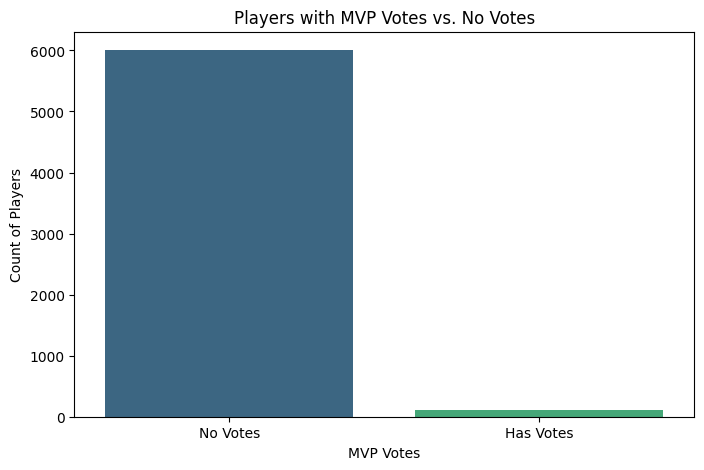

Only 1.88% of players received MVP votes in this dataset


In [ ]:
# Players with and without MVP Votes
vote_counts = master_df['pts_share'].apply(lambda x: 'Has Votes' if x > 0 else 'No Votes').value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=vote_counts.index, y=vote_counts.values, palette='viridis')
plt.title("Players with MVP Votes vs. No Votes")
plt.ylabel("Count of Players")
plt.xlabel("MVP Votes")
plt.show()

# What % of players actually received votes?
vote_pct = (master_df['pts_share'] > 0).mean() * 100
print(f"Only {vote_pct:.2f}% of players received MVP votes in this dataset")



I verified that all merged player-season entries had valid combinations of player name, season, and performance metrics, with no unexpected outliers or duplicate rows

Next I verified the presence of fully duplicated rows across all columns, while preserving player-season entries that represent trades or multi-team seasons

In [ ]:
duplicate = master_df[master_df.duplicated()]
print(f"Total Duplicate Rows: {len(duplicate)}")

#if there are duplicate rows, show first ten, if not say no duplicates
if len(duplicate) > 0:
    print("First 10 Duplicate Rows:")
    print(duplicate.head(10))
else:
    print("No Duplicate Rows Found")

#duplicates ignoring team (trades midseason)
duplicates_clean = master_df[master_df.duplicated(subset=master_df.columns.difference(['nba_team_id']), keep=False)]
print(f"Duplicate Rows Ignoring Team: {len(duplicates_clean)}")

Total Duplicate Rows: 0
No Duplicate Rows Found
Duplicate Rows Ignoring Team: 0


In [ ]:
print("Total Rows in master_df:", len(master_df))
print("Missing Player Names:", master_df['display_name'].isnull().sum())
print("Missing MVP Votes:", (master_df['pts_share'] == 0).sum())
print("Missing Player ID:", (master_df['nba_person_id'] == 0).sum())
print("Unique Players:", master_df['display_name'].nunique())
print("Total Seasons:", master_df['nba_season'].nunique())
print("Players without MVP Votes:", master_df[master_df['pts_share'] == 0]['display_name'].nunique())


Total Rows in master_df: 6121
Missing Player Names: 0
Missing MVP Votes: 0
Missing Player ID: 0
Unique Players: 411
Total Seasons: 9
Players without MVP Votes: 0


Focusing on features with the strongest positive and negative correlation to MVP voting share, plotted the correlation heat maps below.

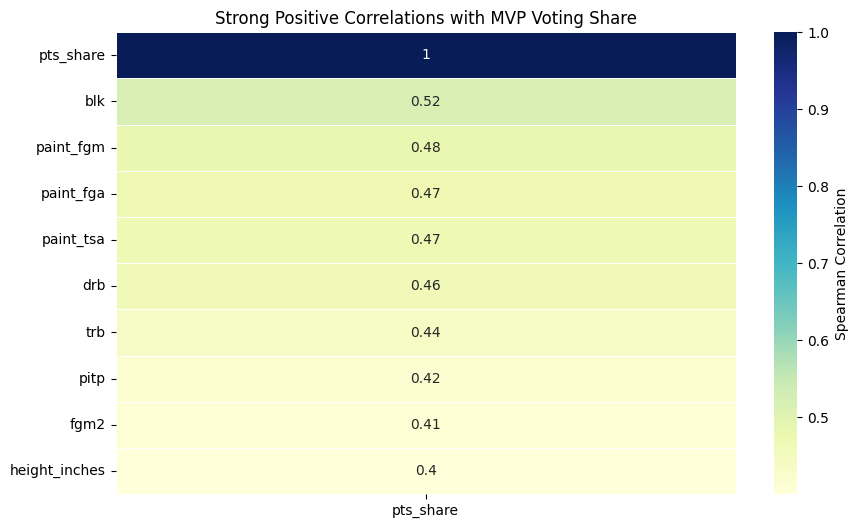

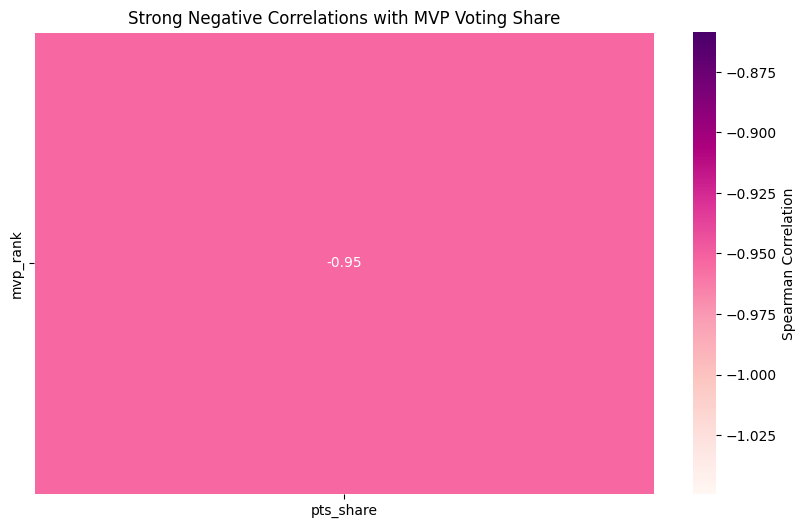

In [ ]:
# Calculate Correlation Matrix -- separating because of amoutn of columns
numeric_df = master_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr(method='spearman')[['pts_share']]

# Filter Positive Correlations
positive_corr = correlation_matrix[correlation_matrix['pts_share'] >= 0.4].sort_values(by='pts_share', ascending=False)

# Filter Negative Correlations
negative_corr = correlation_matrix[correlation_matrix['pts_share'] <= -0.4].sort_values(by='pts_share')

# Plot Positive Correlations
plt.figure(figsize=(10, 6))
sns.heatmap(positive_corr, annot=True, cmap='YlGnBu', linewidths=0.5, cbar_kws={'label': 'Spearman Correlation'})
plt.title("Strong Positive Correlations with MVP Voting Share")
plt.show()

# Plot Negative Correlations
plt.figure(figsize=(10, 6))
sns.heatmap(negative_corr, annot=True, cmap='RdPu', linewidths=0.5, cbar_kws={'label': 'Spearman Correlation'})
plt.title("Strong Negative Correlations with MVP Voting Share")
plt.show()



# 5. Feature Engineering

In this section, I engineered custom basketball metrics designed to capture the qualities that define an MVP player — including scoring efficiency, on/off court impact, and team success. These features combine traditional box score data with advanced basketball concepts to provide a more comprehensive measure of player value. These were calculated at player-season level, reflecting a player's performance across all teams in a given WNBA season. This accounts for players traded mid-season.

In [ ]:
# Aggregate Across Teams Per Season
season_df = master_df.groupby(['nba_person_id', 'nba_season']).agg({
    'pts': 'sum',
    'ast': 'sum',
    'trb': 'sum',
    'mp': 'sum',
    'fga': 'sum',
    'fta': 'sum',
    'blk': 'sum',
    'paint_fgm': 'sum',
    'paint_tsa': 'sum',
    'drb': 'sum',
    'trb': 'sum',
    'pitp': 'sum',
    'fgm2': 'sum',
    'height_inches': 'mean',
    'pts_on_court': 'sum',
    'pts_off_court': 'sum',
    'pts_opp_on': 'sum',
    'pts_opp_off': 'sum',
    'possessions': 'sum',
    'pts_off_tov_allowed_opp_on': 'sum',
    'pts_off_tov_allowed_opp_off': 'sum',
    'wlp': 'mean',  # Team Win Percentage
    'clutch_time_seconds': 'sum',
}).reset_index()

**Net Rating Differential**

Measures how much better or worse a player's team performs with them on the court versus off the court. Higher net ratings indicate players who consistently elevate their team's performance.

In [ ]:
# = (team points on court - oppononent points on court) / possessions

season_df['net_rating_on'] = (season_df['pts_on_court'] - season_df['pts_off_tov_allowed_opp_on']) / season_df['possessions']
season_df['net_rating_off'] = (season_df['pts_off_court'] - season_df['pts_off_tov_allowed_opp_off']) / season_df['possessions']
season_df['impact_rating'] = season_df['net_rating_on'] - season_df['net_rating_off']


**Efficiency Per Minute**

Evaluates how productive a player is relative to their playing time. MVP candidates tend to combine high production with limited playing time, making this a valuable indicator of elite performance.

In [ ]:
season_df['efficiency_per_min'] = (season_df['pts'] + season_df['ast'] + season_df['trb']) / season_df['mp']

**Usage-Adjusted Scoring**

Adjusts raw scoring totals based on how involved the player is in their team's offensive possessions.


In [ ]:
season_df['usage_adj_scoring'] = season_df['pts'] * (season_df['possessions'] / season_df['mp'])

**Win Contribution**

Winning is a crucial component of the MVP award. This feature combines individual scoring production with team win percentage -it gives a sense of how valuable a player's scoring is in terms of helping the team win games.

In [ ]:
season_df['win_contribution'] = season_df['pts'] * season_df['wlp']

**True Shooting Percentage**

Shooting performance metric that combines field goals and free throws– utilizing 0.44 multiplier because not all free throws take up a possession.

In [ ]:
season_df['true_shooting_perc'] = season_df['pts'] / (2 * (season_df['fga'] + 0.44 * season_df['fta']))

**Defensive Box Plus Minus**

Combines defensive statistics (blocks and defensive rebounds) against minutes played to represent defensive impact while on court.


In [ ]:
# Defensive Box Plus Minus (DBPM)
season_df['dbpm'] = (season_df['blk'] + season_df['drb']) / season_df['mp']
season_df['dbpm'] = season_df['dbpm'].fillna(0)  # Avoid NaNs for low-minute players


**Total Rebound per Min**

Measures total rebounds per minutes played to represent their impact on both sides of the boards.

In [ ]:
season_df['trb_per_min'] = season_df['trb'] / season_df['mp']
season_df['trb_per_min'] = season_df['trb_per_min'].fillna(0)


# 6. Feature Selection

Two methods are used to determine which features will be selected in the modeling training-- Spearman Correlation and Recursive Feature Elimination (RFE).

In [ ]:
# Re-Merge MVP Votes AFTER Aggregation
season_df = season_df.merge(master_df[['nba_person_id', 'nba_season', 'pts_share']],
                            on=['nba_person_id', 'nba_season'],
                            how='left')


In [ ]:
print("Columns in season_df:", season_df.columns)
print("Does pts_share exist?", 'pts_share' in season_df.columns)


Columns in season_df: Index(['nba_person_id', 'nba_season', 'pts', 'ast', 'trb', 'mp', 'fga', 'fta',
       'blk', 'paint_fgm', 'paint_tsa', 'drb', 'pitp', 'fgm2', 'height_inches',
       'pts_on_court', 'pts_off_court', 'pts_opp_on', 'pts_opp_off',
       'possessions', 'pts_off_tov_allowed_opp_on',
       'pts_off_tov_allowed_opp_off', 'wlp', 'clutch_time_seconds',
       'net_rating_on', 'net_rating_off', 'impact_rating',
       'efficiency_per_min', 'usage_adj_scoring', 'win_contribution',
       'true_shooting_perc', 'dbpm', 'trb_per_min', 'pts_share'],
      dtype='object')
Does pts_share exist? True


<ipython-input-176-9df8e5aba508>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_spearman.index, y=top_spearman.values, palette='mako')


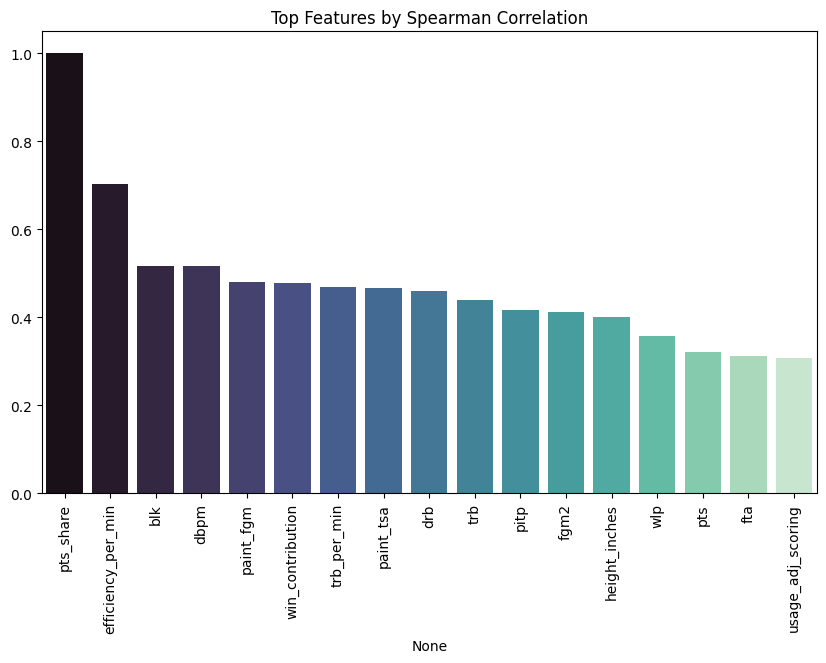

In [ ]:
# Spearman Correlation
spearman_corr = season_df.corr(method='spearman')['pts_share'].sort_values(ascending=False)
top_spearman = spearman_corr[spearman_corr.abs() > 0.3]  # Only keep meaningful correlations

plt.figure(figsize=(10, 6))
sns.barplot(x=top_spearman.index, y=top_spearman.values, palette='mako')
plt.xticks(rotation=90)
plt.title("Top Features by Spearman Correlation")
plt.show()


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
# Fill remaining NaNs in pts_share (this should be done **right before RFE**)
season_df['pts_share'] = season_df['pts_share'].fillna(0)
season_df.replace([np.inf, -np.inf], np.nan, inplace=True)
season_df.fillna(0, inplace=True)

# Define Features + Target
X = season_df.drop(['nba_person_id', 'nba_season', 'pts_share'], axis=1)
y = season_df['pts_share']


# RFE
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=10)
rfe.fit(X, y)

# What Did RFE Pick?
rfe_features = X.columns[rfe.support_]
print("Top RFE Features:", list(rfe_features))


Top RFE Features: ['paint_fgm', 'pitp', 'pts_off_tov_allowed_opp_on', 'wlp', 'clutch_time_seconds', 'net_rating_off', 'impact_rating', 'efficiency_per_min', 'win_contribution', 'true_shooting_perc']


# 7. Model Training

Random Forest Regressor model- compare both baseline performance of one feature to the features selected via RFE. Implemented hyperparameter tuning (GridSearchCV) to improve performance.

In [ ]:
X_baseline = season_df[['efficiency_per_min']]
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_baseline, y, test_size=0.2, random_state=42)

rf_baseline = RandomForestRegressor(n_estimators=100, random_state=42)
rf_baseline.fit(X_train_b, y_train_b)

y_pred_b = rf_baseline.predict(X_test_b)
print("Baseline Model MSE:", mean_squared_error(y_test_b, y_pred_b))
print("Baseline R² Score:", r2_score(y_test_b, y_pred_b))


Baseline Model MSE: 0.0018581636263673472
Baseline R² Score: 0.5540309462141104


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Separate 2024 from the rest
season_df_2024 = season_df[season_df['nba_season'] == 2024]
season_df = season_df[season_df['nba_season'] != 2024]


# Use only the RFE-selected features
X_rfe = season_df[['paint_fgm', 'pitp', 'pts_off_tov_allowed_opp_on', 'wlp', 'blk', 'trb_per_min',
                   'clutch_time_seconds', 'net_rating_off', 'impact_rating',
                   'efficiency_per_min', 'win_contribution', 'true_shooting_perc']]
y = season_df['pts_share']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict & Evaluate
y_pred = rf.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


MSE: 0.0005164836258220502
R² Score: 0.79986943404072


<ipython-input-93-34d211587721>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


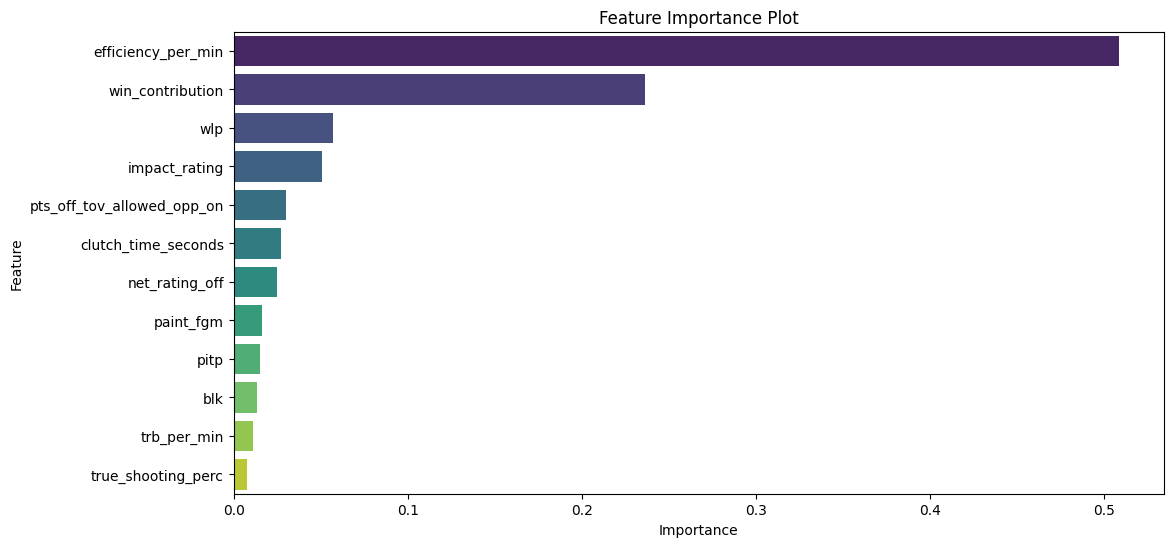

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances
importances = rf.feature_importances_
features = X_rfe.columns

# Put into DataFrame for easier plotting
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance Plot')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2', verbose=2)
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate best model
best_rf = grid_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test)
print("Tuned MSE:", mean_squared_error(y_test, y_pred_tuned))
print("Tuned R² Score:", r2_score(y_test, y_pred_tuned))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.3s
[CV] END m

# 8. 2024 MVP Prediction

Using model to create 2024 predictions.

In [ ]:
season_df_2024.columns

Index(['nba_person_id', 'nba_season', 'pts', 'ast', 'trb', 'mp', 'fga', 'fta',
       'blk', 'paint_fgm', 'paint_tsa', 'drb', 'pitp', 'fgm2', 'height_inches',
       'pts_on_court', 'pts_off_court', 'pts_opp_on', 'pts_opp_off',
       'possessions', 'pts_off_tov_allowed_opp_on',
       'pts_off_tov_allowed_opp_off', 'wlp', 'clutch_time_seconds',
       'net_rating_on', 'net_rating_off', 'impact_rating',
       'efficiency_per_min', 'usage_adj_scoring', 'win_contribution',
       'true_shooting_perc', 'dbpm', 'trb_per_min', 'pts_share'],
      dtype='object')

In [ ]:
# 1. Filter out the 2024 season data

# 2. Prepare the 2024 Feature Set with Selected Features
X_2024 = season_df_2024[['paint_fgm', 'pitp', 'pts_off_tov_allowed_opp_on', 'wlp', 'blk', 'trb_per_min',
                      'clutch_time_seconds', 'net_rating_off', 'impact_rating',
                      'efficiency_per_min', 'win_contribution', 'true_shooting_perc']]

# 3. Make Predictions using the Tuned Model
y_2024_pred = best_rf.predict(X_2024)

# 4. Attach Predictions Back to the DataFrame
season_df_2024.loc[:, 'MVP_Likelihood'] = y_2024_pred

# Merge Display Names at the End
season_df_2024 = season_df_2024.merge(master_df[['nba_person_id', 'display_name','nba_season']], on=['nba_person_id','nba_season'], how='left')
# this query needs to merge on

# Show Top 10 Players with Highest MVP Likelihood
top_mvp_candidates = season_df_2024[['display_name', 'MVP_Likelihood']].sort_values(by='MVP_Likelihood', ascending=False).head(10)
print(top_mvp_candidates)


           display_name  MVP_Likelihood
5180        A'ja Wilson        0.717339
1054    Breanna Stewart        0.681281
5187   Napheesa Collier        0.583213
69417     Caitlin Clark        0.244170
9       Brittney Griner        0.082694
5181    Sabrina Ionescu        0.078406
1048      Dearica Hamby        0.067683
9299    Chennedy Carter        0.066562
5185   Arike Ogunbowale        0.059722
2          Tina Charles        0.048069
